# Online data test

In [15]:
import numpy as np
from scipy.io import loadmat, savemat
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Reshape, Dropout
from keras.losses import categorical_crossentropy
from keras import regularizers
import keras.backend as K
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import Sequence, to_categorical, plot_model
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
import os
from lzy_utils import readdata, get_sub_sequences
from sklearn import preprocessing

In [2]:
os.getcwd()

'C:\\Users\\Zed_Luz\\OneDrive\\3-MEE\\21-NUS Lab Intern\\Work\\3-IMU-DeepLearning\\Zeyu\\1-Python Files'

## train data in CNNs model

### Import data and save as dict and list

In [9]:
DatasetPath = r'C:\Users\Zed_Luz\OneDrive - 南方科技大学\BigScaleFiles\1-datasets for bilateral lower limb neuromechanical signals\2-Data'
#OnlineDatapath = r'C:\Users\Zed_Luz\OneDrive - 南方科技大学\BigScaleFiles\1-datasets for bilateral lower limb neuromechanical signals\2-Data\AB185\Processed\AB185_Circuit_001_post.csv'
OnlineDatapath = dict()
IfMaxAbsPreprocess = True
Subjects = []# ['AB185', 'AB186',...]
for (dirpath, dirnames, filenames) in os.walk(DatasetPath):
    Subjects.extend(dirnames)
    break
DataType = [] # ['Features', 'MVC', 'Processed', 'Raw']
for (dirpath, dirnames, filenames) in os.walk(os.path.join(DatasetPath,Subjects[0])):
    DataType.extend(dirnames)
    break
DataFileName = [] # ['Features', 'MVC', 'Processed', 'Raw']
for (dirpath, dirnames, filenames) in os.walk(os.path.join(DatasetPath,Subjects[0],DataType[2])):
    DataFileName.extend(filenames)
    break
data1 = os.path.join(DatasetPath,Subjects[0],DataType[2], DataFileName[0])
data2 = os.path.join(DatasetPath,Subjects[0],DataType[2], DataFileName[10])
array_data1, dict_data1, rowcount1, colcount1, categories1, label_prep1 = readdata(data1)
array_data2, dict_data2, rowcount2, colcount2, categories2, label_prep2 = readdata(data2)
Train_data = array_data1
Val_data = array_data2

### preprocess_MaxAbs

In [10]:
if IfMaxAbsPreprocess:
    max_abs_scaler = preprocessing.MaxAbsScaler()
    Train_data = max_abs_scaler.fit_transform(Train_data)
    Val_data = max_abs_scaler.fit_transform(Val_data)

### setup time sequence and select channels to be trained 

In [11]:
labelcategories = ['Sitting','Level Ground Walking','Ramp Ascent','Ramp Descent','Stair Ascent','Stair Descent',
                       'Standing']
print(len(categories1),'All of Data types:',categories1)
selectedchannels = ['Right_Shank_Ax', 'Right_Shank_Ay', 'Right_Shank_Az', 'Right_Shank_Gy', 
                    'Right_Shank_Gz', 'Right_Shank_Gx', 'Right_Thigh_Ax', 'Right_Thigh_Ay', 
                    'Right_Thigh_Az', 'Right_Thigh_Gy', 'Right_Thigh_Gz', 'Right_Thigh_Gx', 
                    'Left_Shank_Ax', 'Left_Shank_Ay', 'Left_Shank_Az', 'Left_Shank_Gy', 
                    'Left_Shank_Gz', 'Left_Shank_Gx', 'Left_Thigh_Ax', 'Left_Thigh_Ay', 
                    'Left_Thigh_Az', 'Left_Thigh_Gy', 'Left_Thigh_Gz', 'Left_Thigh_Gx', 
                    'Waist_Ax', 'Waist_Ay', 'Waist_Az', 'Waist_Gy', 'Waist_Gz', 'Waist_Gx',
                    'Right_Ankle', 'Right_Knee', 'Left_Ankle', 'Left_Knee', 
                    'Right_Ankle_Velocity', 'Right_Knee_Velocity', 
                    'Left_Ankle_Velocity', 'Left_Knee_Velocity']

selectedindex = [categories1.index(selectedchannels[i]) 
                    for i in range(len(selectedchannels))]
selectedchannelsNum = len(selectedchannels)
selecteddatain_train = Train_data[:,selectedindex]
selecteddatain_val = Val_data[:,selectedindex]
label_train = dict_data1['Mode']
label_train_prep = to_categorical(label_train)
label_val = dict_data2['Mode']
label_val_prep = to_categorical(label_val)
exp_dur_train = rowcount1/500 # sample rate: 500Hz
exp_dur_val = rowcount2/500 # sample rate: 500Hz
nfeat = selectedchannelsNum
t_train = np.linspace(0, exp_dur_train, rowcount1)
t_val = np.linspace(0, exp_dur_val, rowcount2)

61 All of Data types: ['Right_Shank_Ax', 'Right_Shank_Ay', 'Right_Shank_Az', 'Right_Shank_Gy', 'Right_Shank_Gz', 'Right_Shank_Gx', 'Right_Thigh_Ax', 'Right_Thigh_Ay', 'Right_Thigh_Az', 'Right_Thigh_Gy', 'Right_Thigh_Gz', 'Right_Thigh_Gx', 'Left_Shank_Ax', 'Left_Shank_Ay', 'Left_Shank_Az', 'Left_Shank_Gy', 'Left_Shank_Gz', 'Left_Shank_Gx', 'Left_Thigh_Ax', 'Left_Thigh_Ay', 'Left_Thigh_Az', 'Left_Thigh_Gy', 'Left_Thigh_Gz', 'Left_Thigh_Gx', 'Waist_Ax', 'Waist_Ay', 'Waist_Az', 'Waist_Gy', 'Waist_Gz', 'Waist_Gx', 'Right_TA', 'Right_MG', 'Right_SOL', 'Right_BF', 'Right_ST', 'Right_VL', 'Right_RF', 'Left_TA', 'Left_MG', 'Left_SOL', 'Left_BF', 'Left_ST', 'Left_VL', 'Left_RF', 'Right_Ankle', 'Right_Knee', 'Left_Ankle', 'Left_Knee', 'Right_Ankle_Velocity', 'Right_Knee_Velocity', 'Left_Ankle_Velocity', 'Left_Knee_Velocity', 'Mode', 'Right_Heel_Contact', 'Right_Heel_Contact_Trigger', 'Right_Toe_Off', 'Right_Toe_Off_Trigger', 'Left_Heel_Contact', 'Left_Heel_Contact_Trigger', 'Left_Toe_Off', 'Left_

### Display train data

Illustate  38 channels of data...


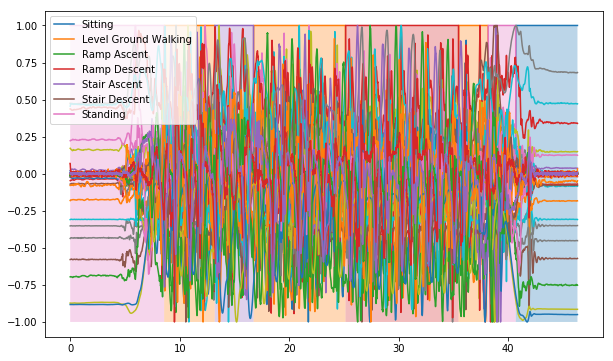

In [12]:
print('Illustate ', selectedchannelsNum, 'channels of data...')
plt.figure(figsize=(10, 6))
cm = plt.get_cmap(name='gist_rainbow')
for i in range(7):
        plt.plot(t_train, label_prep1[:,i]*selecteddatain_train.max(), label=labelcategories[i])
        plt.set_cmap(cm)
        plt.fill_between(t_train, label_prep1[:,i]*selecteddatain_train.min(), 
                         label_prep1[:,i]*selecteddatain_train.max(), alpha=0.3)
plt.plot(t_train, selecteddatain_train)
plt.legend()
plt.show()

### CNNs configuration to cut window on time series data. 

In [13]:
win_size = 100
step_leng = 20
data_seq_train_Oshape, label_seq_train = get_sub_sequences(selecteddatain_train, 
                                                    label_train_prep, window_size=win_size, step_size=step_leng)
data_seq_train = np.reshape(data_seq_train_Oshape, newshape=(data_seq_train_Oshape.shape[0], data_seq_train_Oshape.shape[1], 
                                                      data_seq_train_Oshape.shape[2], 1))
data_seq_val_Oshape, label_seq_val = get_sub_sequences(selecteddatain_val, label_val_prep, window_size=win_size,
                                                step_size=step_leng)
data_seq_val = np.reshape(data_seq_val_Oshape, newshape=(data_seq_val_Oshape.shape[0], data_seq_val_Oshape.shape[1], 
                                                  data_seq_val_Oshape.shape[2], 1))

### CNNs model1

In [14]:
cnn_model1 = Sequential()
cnn_model1.add(Conv2D(filters=128, kernel_size=(15,data_seq_train.shape[2]), input_shape=(win_size, data_seq_train.shape[2], 1),
                      data_format='channels_last', activation='relu', padding='valid'))
cnn_model1.add(MaxPooling2D(pool_size=(2, 1), padding='valid', data_format='channels_last'))
cnn_model1.add(Reshape((cnn_model1.output_shape[1],cnn_model1.output_shape[3],1), input_shape=cnn_model1.output_shape[1:4]))
cnn_model1.add(Conv2D(filters=256, kernel_size=(12,cnn_model1.output_shape[2]), input_shape=cnn_model1.output_shape[1:4],
                      data_format='channels_last', activation='relu', padding='valid'))
cnn_model1.add(MaxPooling2D(pool_size=(2,1), padding='valid', data_format='channels_last'))
cnn_model1.add(Flatten())
cnn_model1.add(Dense(label_train_prep.shape[1], activation='softmax'))
#cnn_model1.add(Dense(3, activation='softmax'))
cnn_model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model1.summary()
cnn_model1.fit(data_seq_train, label_seq_train, epochs= 10, batch_size=128)
score = cnn_model1.evaluate(data_seq_val, label_seq_val)
print('Evaluation Loss:', score[0],'Evaluation Accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 86, 1, 128)        73088     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 43, 1, 128)        0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 43, 128, 1)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 1, 256)        393472    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 1, 256)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 28679     
Total para

### Model1 adding Dropout

In [16]:
cnn_model2 = Sequential()
cnn_model2.add(Conv2D(filters=128, kernel_size=(15,data_seq_train.shape[2]), input_shape=(win_size, data_seq_train.shape[2], 1),
                      data_format='channels_last', activation='relu', padding='valid'))
cnn_model2.add(MaxPooling2D(pool_size=(2, 1), padding='valid', data_format='channels_last'))
cnn_model2.add(Dropout(0.25))
cnn_model2.add(Reshape((cnn_model1.output_shape[1],cnn_model1.output_shape[3],1), input_shape=cnn_model1.output_shape[1:4]))
cnn_model2.add(Conv2D(filters=256, kernel_size=(12,cnn_model1.output_shape[2]), input_shape=cnn_model1.output_shape[1:4],
                      data_format='channels_last', activation='relu', padding='valid'))
cnn_model2.add(MaxPooling2D(pool_size=(2,1), padding='valid', data_format='channels_last'))
cnn_model2.add(Dropout(0.25))
cnn_model2.add(Flatten())
cnn_model2.add(Dense(label_train_prep.shape[1], activation='softmax'))
#cnn_model1.add(Dense(3, activation='softmax'))
cnn_model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model2.summary()
cnn_model2.fit(data_seq_train, label_seq_train, epochs= 10, batch_size=128)
score = cnn_model2.evaluate(data_seq_val, label_seq_val)
print('Evaluation Loss:', score[0],'Evaluation Accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 86, 1, 128)        73088     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 43, 1, 128)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 43, 1, 128)        0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 43, 128, 1)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 1, 256)        393472    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 1, 256)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 1, 256)        0         
__________

#### After adding dropout layers, there is higher accuracy. 

### Test Section, you can run this block after CNNs train to evaluate on different set.

In [ ]:
#%%Evaluation for different sets
TestTrail = 4
data2 = os.path.join(DatasetPath,Subjects[0],DataType[2], DataFileName[TestTrail])
array_data2, dict_data2, rowcount2, colcount2, categories2, label_prep2 = readdata(data2)
Val_data = array_data2
selecteddatain_val = Val_data[:,selectedindex]
label_val = dict_data2['Mode']
label_val_prep = to_categorical(label_val)
data_seq_val, label_seq_val = get_sub_sequences(selecteddatain_val, label_val_prep, window_size=100, step_size=2)
data_seq_val = np.reshape(data_seq_val, newshape=(data_seq_val.shape[0], data_seq_val.shape[1], data_seq_val.shape[2], 1))
score = cnn_model1.evaluate(data_seq_val, label_seq_val)
print('Evaluation Loss:', score[0],'Evaluation Accuracy:', score[1])